In [27]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.combine import SMOTEENN

# Load dataset
file_path = '(MENTAH) Kab Bekasi berdasarkan BBLA PBLA Februari 2024 (2255).xlsx'
df = pd.read_excel(file_path)
df.head()

,No,NIK,Nama,JK,Tgl Lahir,BB Lahir,TB Lahir,Nama Ortu,Prov,Kab/Kota,...,ZS BB/U,TB/U,ZS TB/U,BB/TB,ZS BB/TB,Naik Berat Badan,PMT Diterima (kg),Jml Vit A,KPSP,KIA
0,1 .,0112192716,RAFFASYA M,L,2019-12-01,2.2,45,SITI A,JAWA BARAT,BEKASI,...,1.36,Normal,2.64,Gizi Baik,-0.42,O,-,1.0,-,-
1,2 .,3216085206210001,SALMA NUR L,L,2021-06-12,2.4,46,syarif w,JAWA BARAT,BEKASI,...,4.49,Normal,1.28,Obesitas,5.38,O,-,1.0,-,-
2,3 .,3216715108209931,SHIFA.A,P,2021-02-02,1.93,40,SRI WIDODO,JAWA BARAT,BEKASI,...,0.93,Normal,-0.61,Risiko Gizi Lebih,1.77,O,-,1.0,-,-
3,4 .,3275056906200005,ASHALINA MELODY NASA,P,2020-06-29,2.2,46,NORWAN NASA MUSTOFA,JAWA BARAT,BEKASI,...,0.41,Normal,2.85,Gizi Baik,-1.97,O,-,1.0,-,-
4,5 .,1813036210190001,SHANUM SARASYA ALAMSAH,P,2019-10-22,2,42,SASTRA ALAMSAH,JAWA BARAT,BEKASI,...,-0.82,Normal,-1.36,Gizi Baik,0.04,O,-,1.0,-,-


============================================================================================PREPROCESSING============================================================================================

- Drop Atribut yang tidak digunakan
- Drop data yang usia saat ukurnya tidak valid (0 Tahun - 0 Bulan - 0 Hari)

In [28]:
# Drop unnecessary columns
df.drop(['No', 'NIK', 'Nama', 'Tgl Lahir', 'Nama Ortu', 'Prov', 'Kab/Kota', 'Kec', 'Pukesmas', 'Desa/Kel', 'Posyandu', 
         'RT', 'RW', 'Alamat', 'Tanggal Pengukuran', 'LiLA', 'Naik Berat Badan', 'PMT Diterima (kg)', 'Jml Vit A', 'KPSP', 'KIA', 'ZS BB/U', 'ZS TB/U', 'ZS BB/TB','BB/U', 'BB/TB'], 
         axis=1, inplace=True)

# Remove data with "0 Tahun - 0 Bulan - 0 Hari" in the 'Usia Saat Ukur' column
df = df[df['Usia Saat Ukur'] != '0 Tahun - 0 Bulan - 0 Hari']
df.index = range(1, len(df) + 1)
df.head()

,JK,BB Lahir,TB Lahir,Usia Saat Ukur,Berat Saat Ukur,Tinggi Saat Ukur,TB/U
1,L,2.2,45,4 Tahun - 2 Bulan - 13 Hari,20.00,116.0,Normal
2,L,2.4,46,2 Tahun - 8 Bulan - 5 Hari,22.95,98.0,Normal
3,P,1.93,40,3 Tahun - 0 Bulan - 13 Hari,15.76,93.0,Normal
4,P,2.2,46,3 Tahun - 7 Bulan - 25 Hari,16.20,112.0,Normal
5,P,2,42,4 Tahun - 4 Bulan - 2 Hari,15.00,99.0,Normal


- Convert (0 Tahun - 0 Bulan - 0 Hari) ke satuan Bulan

In [29]:
# Convert 'Usia Saat Ukur' to months
def convert_to_months(age_str):
    pattern = r'(\d+)\s*Tahun\s*-\s*(\d+)\s*Bulan\s*-\s*(\d+)\s*Hari'
    match = re.match(pattern, age_str)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        total_months = years * 12 + months
        return total_months
    return None

df['Usia Saat Ukur'] = df['Usia Saat Ukur'].apply(convert_to_months)
df.head()

,JK,BB Lahir,TB Lahir,Usia Saat Ukur,Berat Saat Ukur,Tinggi Saat Ukur,TB/U
1,L,2.2,45,50,20.00,116.0,Normal
2,L,2.4,46,32,22.95,98.0,Normal
3,P,1.93,40,36,15.76,93.0,Normal
4,P,2.2,46,43,16.20,112.0,Normal
5,P,2,42,52,15.00,99.0,Normal


In [30]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values) if not missing_values.empty else print("Tidak ada missing values.")
print(df.dtypes)

TB/U    7
dtype: int64
JK                   object
BB Lahir             object
TB Lahir             object
Usia Saat Ukur        int64
Berat Saat Ukur     float64
Tinggi Saat Ukur    float64
TB/U                 object
dtype: object


- Menghapus data yang nilainya kosong
- Encoding Jenis Kelamin dari L/P menjadi 0/1
- Encoding TB/U (target) menjadi 0 dan 1
- Mengubah semua data menjadi numerik

In [31]:
# Encode gender (JK) and normalize 'TB/U'
df['JK'] = df['JK'].str.strip().map({'L': 0, 'P': 1})
df['TB/U'] = df['TB/U'].map({'Tinggi': 0, 'Normal': 0, 'Pendek': 1, 'Sangat Pendek': 1})

# Handle missing values and outliers
df = df.dropna(subset=['TB/U', 'BB Lahir', 'TB Lahir'])
df['TB/U'] = df['TB/U'].astype(int)

# Remove any unwanted non-numeric characters, including spaces or hidden characters, and convert to float
df['BB Lahir'] = df['BB Lahir'].replace({r'\s+': ''}, regex=True)  # Remove spaces
df['TB Lahir'] = df['TB Lahir'].replace({r'\s+': ''}, regex=True)  # Remove spaces

df['BB Lahir'] = pd.to_numeric(df['BB Lahir'], errors='coerce').round(1)
df['TB Lahir'] = pd.to_numeric(df['TB Lahir'], errors='coerce').astype(int)

print(df.isnull().sum())
df.head()

JK                  0
BB Lahir            0
TB Lahir            0
Usia Saat Ukur      0
Berat Saat Ukur     0
Tinggi Saat Ukur    0
TB/U                0
dtype: int64


,JK,BB Lahir,TB Lahir,Usia Saat Ukur,Berat Saat Ukur,Tinggi Saat Ukur,TB/U
1,0,2.2,45,50,20.00,116.0,0
2,0,2.4,46,32,22.95,98.0,0
3,1,1.9,40,36,15.76,93.0,0
4,1,2.2,46,43,16.20,112.0,0
5,1,2.0,42,52,15.00,99.0,0


In [32]:
df.describe()

,JK,BB Lahir,TB Lahir,Usia Saat Ukur,Berat Saat Ukur,Tinggi Saat Ukur,TB/U
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.00000,2233.000000,2233.000000
mean,0.496641,2.061979,42.968204,30.806986,40.12584,87.322884,0.066726
std,0.500101,0.320423,6.351443,17.268331,473.43844,14.458819,0.249603
min,0.000000,0.300000,0.000000,0.000000,2.50000,47.000000,0.000000
25%,0.000000,1.900000,43.000000,16.000000,9.30000,77.500000,0.000000
50%,0.000000,2.100000,45.000000,31.000000,12.10000,89.000000,0.000000
75%,1.000000,2.300000,46.000000,45.000000,14.70000,99.000000,0.000000
max,1.000000,2.500000,46.000000,60.000000,9674.00000,120.000000,1.000000


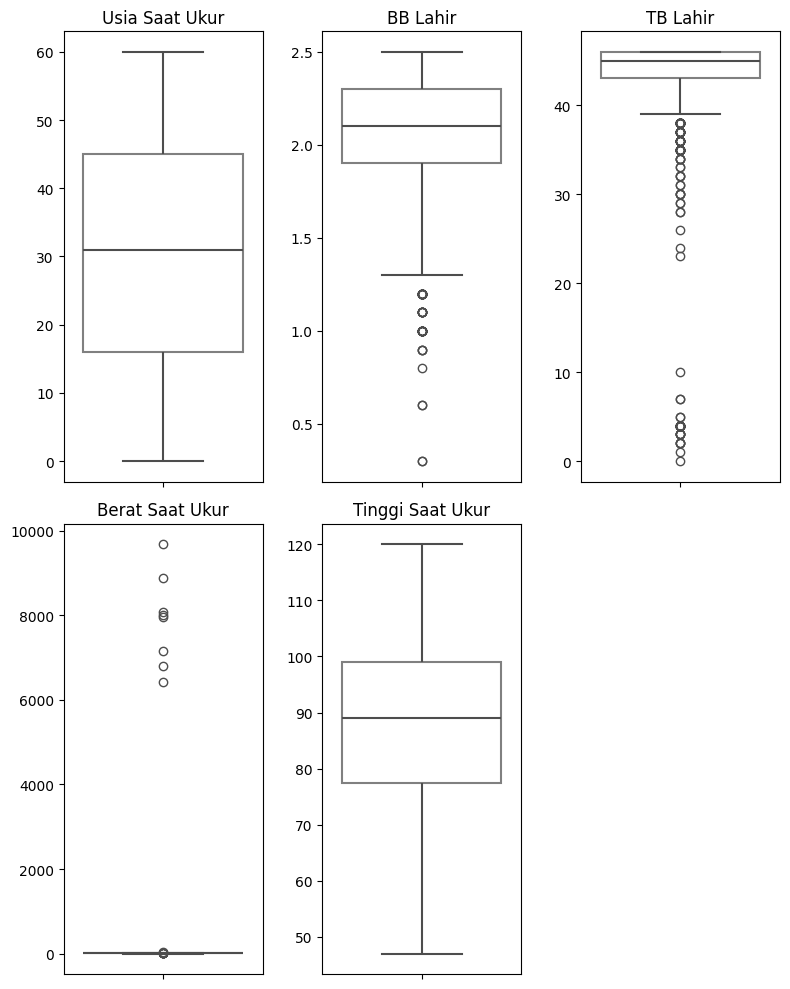

In [33]:
features = ['Usia Saat Ukur', 'BB Lahir', 'TB Lahir', 'Berat Saat Ukur', 'Tinggi Saat Ukur']
plt.figure(figsize=(8, 10))

for i, feature in enumerate(features, 1):
    ax = plt.subplot(2, 3, i)
    sns.boxplot(y=df[feature], linewidth=1.5, color='grey', boxprops=dict(edgecolor='grey', facecolor='none'), ax=ax)
    ax.set_title(feature)
    ax.set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

- Handling Outlier

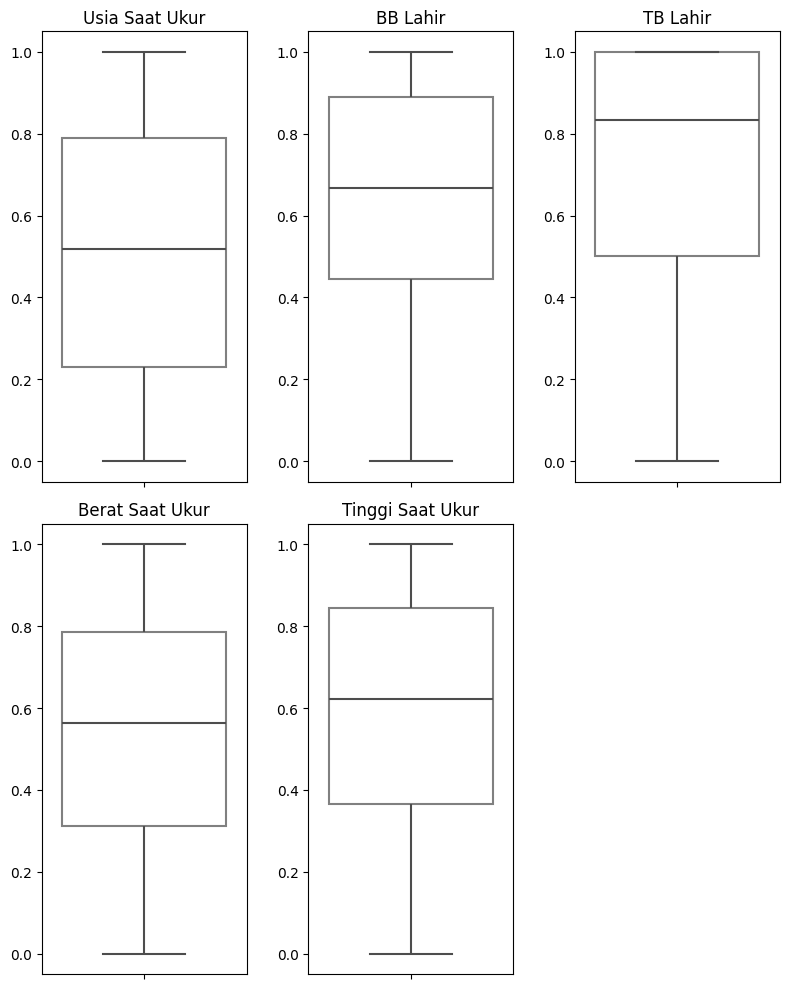

In [34]:
# Handle outliers and normalizing data
def handle_outliers_with_iqr(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.8 * IQR
        upper_bound = Q3 + 1.8 * IQR

        median = df[feature].median()
        df[feature] = df[feature].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

    return df

def apply_winsorization(df, features, limits=[0.05, 0.075]):
    for feature in features:
        df[feature] = winsorize(df[feature], limits=limits)
    return df

def scale_features(df, features):
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])
    return df

# Visualize boxplots before and after handling outliers
def plot_boxplots(df, features):
    plt.figure(figsize=(8, 10))
    for i, feature in enumerate(features, 1):
        ax = plt.subplot(2, 3, i)
        sns.boxplot(y=df[feature], linewidth=1.5, color='grey', 
                    boxprops=dict(edgecolor='grey', facecolor='none'), ax=ax)
        ax.set_title(feature)
        ax.set_ylabel('')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()

# List of features to handle
features = ['Usia Saat Ukur', 'BB Lahir', 'TB Lahir', 'Berat Saat Ukur', 'Tinggi Saat Ukur']

# Handle outliers, winsorization, and normalization
df = handle_outliers_with_iqr(df, features)
df = apply_winsorization(df, features)
df = scale_features(df, features)

# Visualize boxplots
plot_boxplots(df, features)

In [35]:
df.describe()

,JK,BB Lahir,TB Lahir,Usia Saat Ukur,Berat Saat Ukur,Tinggi Saat Ukur,TB/U
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000
mean,0.496641,0.651142,0.706449,0.514813,0.545123,0.585437,0.066726
std,0.500101,0.300545,0.310400,0.325423,0.294895,0.301747,0.249603
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.444444,0.500000,0.230769,0.312500,0.366667,0.000000
50%,0.000000,0.666667,0.833333,0.519231,0.562500,0.622222,0.000000
75%,1.000000,0.888889,1.000000,0.788462,0.785714,0.844444,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


==========================================================================================Pemisahan Data==========================================================================================

In [36]:
print("Jumlah per kelas pada Data Sebelum Pemisahan:")
print(df['TB/U'].value_counts()) 

Jumlah per kelas pada Data Sebelum Pemisahan:
TB/U
0    2084
1     149
Name: count, dtype: int64


- Pengambilan Data Testing (75 sampel dari tiap kelas)

In [37]:
# Select 100 positive and 100 negative samples for testing
positive_samples = df[df['TB/U'] == 1].sample(n=75, random_state=42)  # Ambil 75 data positif
negative_samples = df[df['TB/U'] == 0].sample(n=75, random_state=42)  # Ambil 75 data negatif
data_testing = pd.concat([positive_samples, negative_samples]) 

# Pisahkan data testing dari data default
data_default = df.drop(data_testing.index) 


In [38]:
print("\nJumlah per kelas pada Data Testing:")
print(data_testing['TB/U'].value_counts()) 

print("\nJumlah per kelas pada Data Trainig/Validasi:")
print(data_default['TB/U'].value_counts()) 


Jumlah per kelas pada Data Testing:
TB/U
1    75
0    75
Name: count, dtype: int64

Jumlah per kelas pada Data Trainig/Validasi:
TB/U
0    2009
1      74
Name: count, dtype: int64


- Penerapan SMOTEENN pada data train validasi

In [39]:
# Apply SMOTE to balance the classes in data_default
X_default = data_default.drop(columns=['TB/U'])  # Fitur dari data default
y_default = data_default['TB/U']  # Target dari data default

# Terapkan SMOTE untuk oversampling kelas minoritas
smote = SMOTEENN(random_state=42)
X_default_resampled, y_default_resampled = smote.fit_resample(X_default, y_default)

# Lihat distribusi kelas setelah SMOTE
print("Distribusi kelas setelah SMOTE (Train):")
print(y_default_resampled.value_counts())

Distribusi kelas setelah SMOTE (Train):
TB/U
1    1907
0    1746
Name: count, dtype: int64


- Pemisahan data train dan validasi dengan rasio (80:20. 70:30, 60:40)

In [40]:
# Split data_default_resampled menjadi training dan testing dengan rasio 80:20
X_train_80, X_val_80, y_train_80, y_val_80 = train_test_split(X_default_resampled, y_default_resampled, test_size=0.2, random_state=42)

# Split data_default_resampled menjadi training dan testing dengan rasio 70:30
X_train_70, X_val_70, y_train_70, y_val_70 = train_test_split(X_default_resampled, y_default_resampled, test_size=0.3, random_state=42)

# Split data_default_resampled menjadi training dan testing dengan rasio 60:40
X_train_60, X_val_60, y_train_60, y_val_60 = train_test_split(X_default_resampled, y_default_resampled, test_size=0.4, random_state=42)

========================================================================================Pelatihan dan Evaluasi========================================================================================

- Fungsi untuk evaluasi (akurasi, presisi, recall, F1-score, confusion matrix, kurva roc)

In [41]:
# Fungsi untuk menampilkan metrik evaluasi 
def display_evaluation_metrics_without_support(model_name, y_true, y_pred):
    # Metrik global
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )
    
    print(f"\nModel: {model_name}")
    print(f"Accuracy\t: {accuracy*100:.2f}%")
    print(f"Precision\t: {precision*100:.2f}% (macro average)")
    print(f"Recall\t\t: {recall*100:.2f}% (macro average)")
    print(f"F1-Score\t: {f1*100:.2f}% (macro average)")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_labels = sorted(set(y_true))
    n_samples = len(y_true)
    
    # Classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    
    print("\nMetrik Per Kelas:")
    for idx, label in enumerate(class_labels):
        label_str = str(label)
        
        # Elemen confusion matrix untuk kelas ini
        TP = cm[idx, idx]  # True Positives
        FN = cm[idx, :].sum() - TP  # False Negatives (actual=class, pred=other)
        FP = cm[:, idx].sum() - TP  # False Positives (actual=other, pred=class)
        TN = n_samples - (TP + FN + FP)  # True Negatives
        
        true_class_accuracy = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
        support = report[label_str]['support']

        print(f"Class {label_str}:")
        print(f"  Akurasi       : {true_class_accuracy*100:.2f}%")
        print(f"  Precision     : {report[label_str]['precision']*100:.2f}%")
        print(f"  Recall        : {report[label_str]['recall']*100:.2f}%")
        print(f"  F1-Score      : {report[label_str]['f1-score']*100:.2f}%")
        print(f"  Support       : {int(support)}")
    
    return accuracy, precision, recall, f1, cm

# Fungsi untuk menggambar confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return cm

# fungsi untuk menggambar ROC curve
def plot_combined_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(8, 6))
    for model_name, model in models.items():
        # Get the predicted probabilities for the positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Plot the diagonal line (chance level)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.title('Combined ROC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

- Pelatihan Model SVM dan Gradient Boosting

In [42]:
# SVM (80:20 split)
svm_80_20 = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42, class_weight='balanced')
svm_80_20.fit(X_train_80, y_train_80)
svm_pred_80 = svm_80_20.predict(X_val_80)

# SVM (70:30 split)
svm_70_30 = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42, class_weight='balanced')
svm_70_30.fit(X_train_70, y_train_70)
svm_pred_70 = svm_70_30.predict(X_val_70)

# SVM (60:40 split)
svm_60_40 = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42, class_weight='balanced')
svm_60_40.fit(X_train_60, y_train_60)
svm_pred_60 = svm_60_40.predict(X_val_60)

# Gradient Boosting (80:20 split)
gb_80_20 = GradientBoostingClassifier(learning_rate=0.05, max_depth=3, n_estimators=50, random_state=42)
weights_80 = compute_sample_weight(class_weight='balanced', y=y_train_80)
gb_80_20.fit(X_train_80, y_train_80, sample_weight=weights_80)
gb_pred_80 = gb_80_20.predict(X_val_80)

# Gradient Boosting (70:30 split)
gb_70_30 = GradientBoostingClassifier(learning_rate=0.05, max_depth=3, n_estimators=50, random_state=42)
weights_70 = compute_sample_weight(class_weight='balanced', y=y_train_70)
gb_70_30.fit(X_train_70, y_train_70, sample_weight=weights_70)
gb_pred_70 = gb_70_30.predict(X_val_70)

# Gradient Boosting (60:40 split)
gb_60_40 = GradientBoostingClassifier(learning_rate=0.05, max_depth=3, n_estimators=50, random_state=42)
weights_60 = compute_sample_weight(class_weight='balanced', y=y_train_60)
gb_60_40.fit(X_train_60, y_train_60, sample_weight=weights_60)
gb_pred_60 = gb_60_40.predict(X_val_60)


- Evaluasi Model SVM dan Gradient Boosting dengan data validasi (akurasi, presisi, recall, F1-score)

In [43]:
# Evaluasi SVM
print("\nEvaluating SVM (80:20)")
accuracy_svm_80, precision_svm_80, recall_svm_80, f1_svm_80, cm_svm_80 = display_evaluation_metrics_without_support("SVM (80:20)", y_val_80, svm_pred_80)
print("\nEvaluating SVM (70:30)")
accuracy_svm_70, precision_svm_70, recall_svm_70, f1_svm_70, cm_svm_70 = display_evaluation_metrics_without_support("SVM (70:30)", y_val_70, svm_pred_70)
print("\nEvaluating SVM (60:40)")
accuracy_svm_60, precision_svm_60, recall_svm_60, f1_svm_60, cm_svm_60 = display_evaluation_metrics_without_support("SVM (60:40)", y_val_60, svm_pred_60)

# Evaluasi Gradient Boosting
print("\nEvaluating Gradient Boosting (80:20)")
accuracy_80, precision_80, recall_80, f1_80, cm_80 = display_evaluation_metrics_without_support("Gradient Boosting (80:20)", y_val_80, gb_pred_80)
print("\nEvaluating Gradient Boosting (70:30)")
accuracy_70, precision_70, recall_70, f1_70, cm_70 = display_evaluation_metrics_without_support("Gradient Boosting (70:30)", y_val_70, gb_pred_70)
print("\nEvaluating Gradient Boosting (60:40)")
accuracy_60, precision_60, recall_60, f1_60, cm_60 = display_evaluation_metrics_without_support("Gradient Boosting (60:40)", y_val_60, gb_pred_60)


Evaluating SVM (80:20)

Model: SVM (80:20)
Accuracy	: 96.03%
Precision	: 96.13% (macro average)
Recall		: 96.09% (macro average)
F1-Score	: 96.03% (macro average)

Metrik Per Kelas:
Class 0:
  Akurasi       : 92.31%
  Precision     : 98.86%
  Recall        : 93.30%
  F1-Score      : 96.00%
  Support       : 373
Class 1:
  Akurasi       : 92.43%
  Precision     : 93.40%
  Recall        : 98.88%
  F1-Score      : 96.07%
  Support       : 358

Evaluating SVM (70:30)

Model: SVM (70:30)
Accuracy	: 96.26%
Precision	: 96.36% (macro average)
Recall		: 96.31% (macro average)
F1-Score	: 96.26% (macro average)

Metrik Per Kelas:
Class 0:
  Akurasi       : 92.73%
  Precision     : 99.05%
  Recall        : 93.56%
  F1-Score      : 96.23%
  Support       : 559
Class 1:
  Akurasi       : 92.84%
  Precision     : 93.66%
  Recall        : 99.07%
  F1-Score      : 96.29%
  Support       : 537

Evaluating SVM (60:40)

Model: SVM (60:40)
Accuracy	: 96.58%
Precision	: 96.76% (macro average)
Recall		: 96.

- Evaluasi Model SVM dan Gradient Boosting data validasi (confusion matrix)

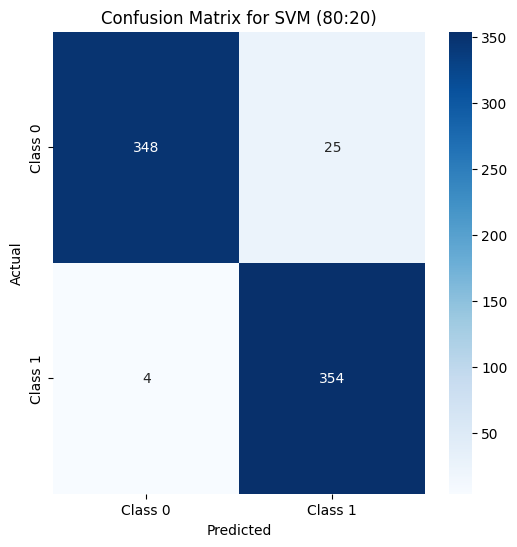

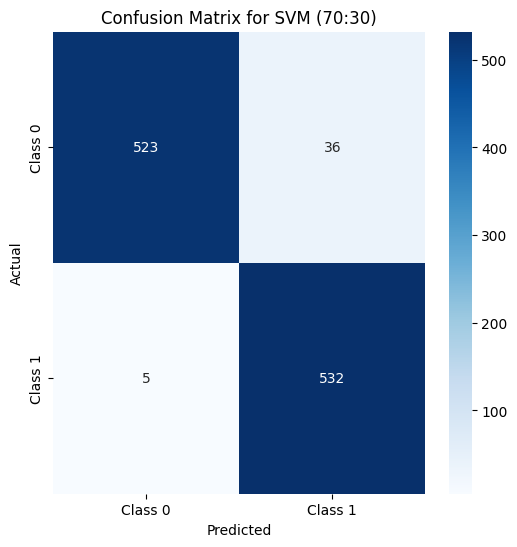

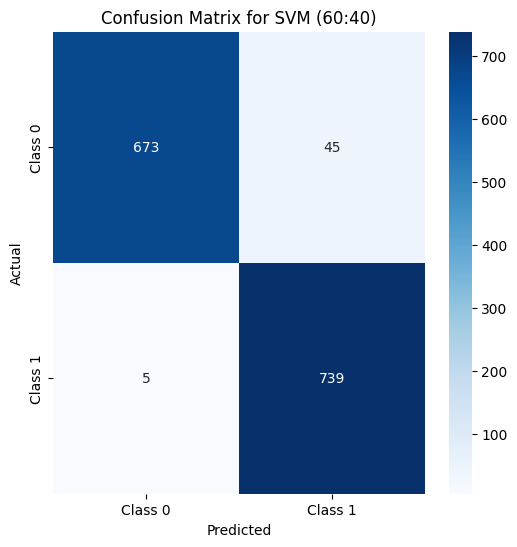

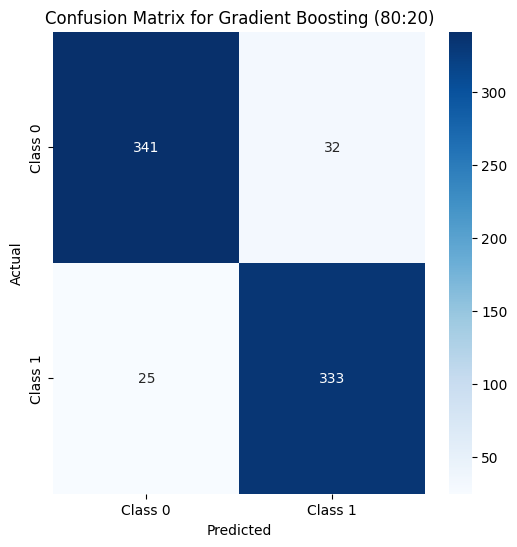

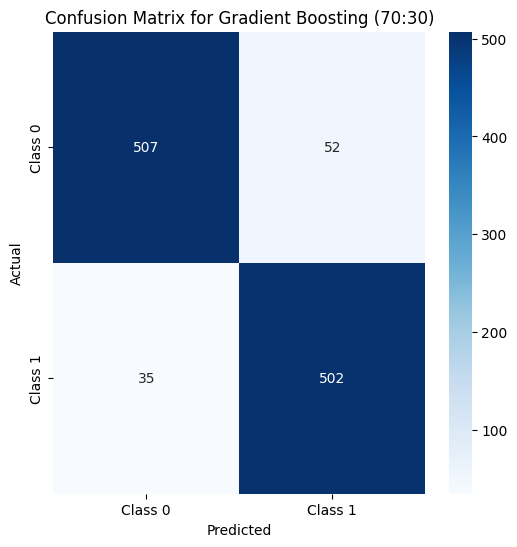

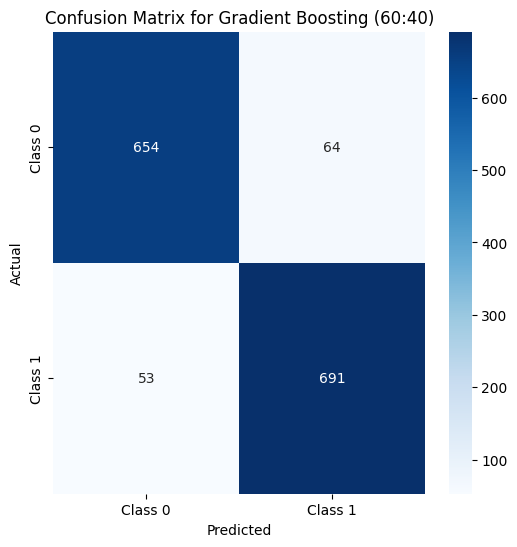

array([[654,  64],
       [ 53, 691]], dtype=int64)

In [44]:
plot_confusion_matrix(y_val_80, svm_pred_80, "SVM (80:20)")
plot_confusion_matrix(y_val_70, svm_pred_70, "SVM (70:30)")
plot_confusion_matrix(y_val_60, svm_pred_60, "SVM (60:40)")

plot_confusion_matrix(y_val_80, gb_pred_80, "Gradient Boosting (80:20)")
plot_confusion_matrix(y_val_70, gb_pred_70, "Gradient Boosting (70:30)")
plot_confusion_matrix(y_val_60, gb_pred_60, "Gradient Boosting (60:40)")

- Evaluasi Model SVM dan Gradient Boosting (kurva ROC)

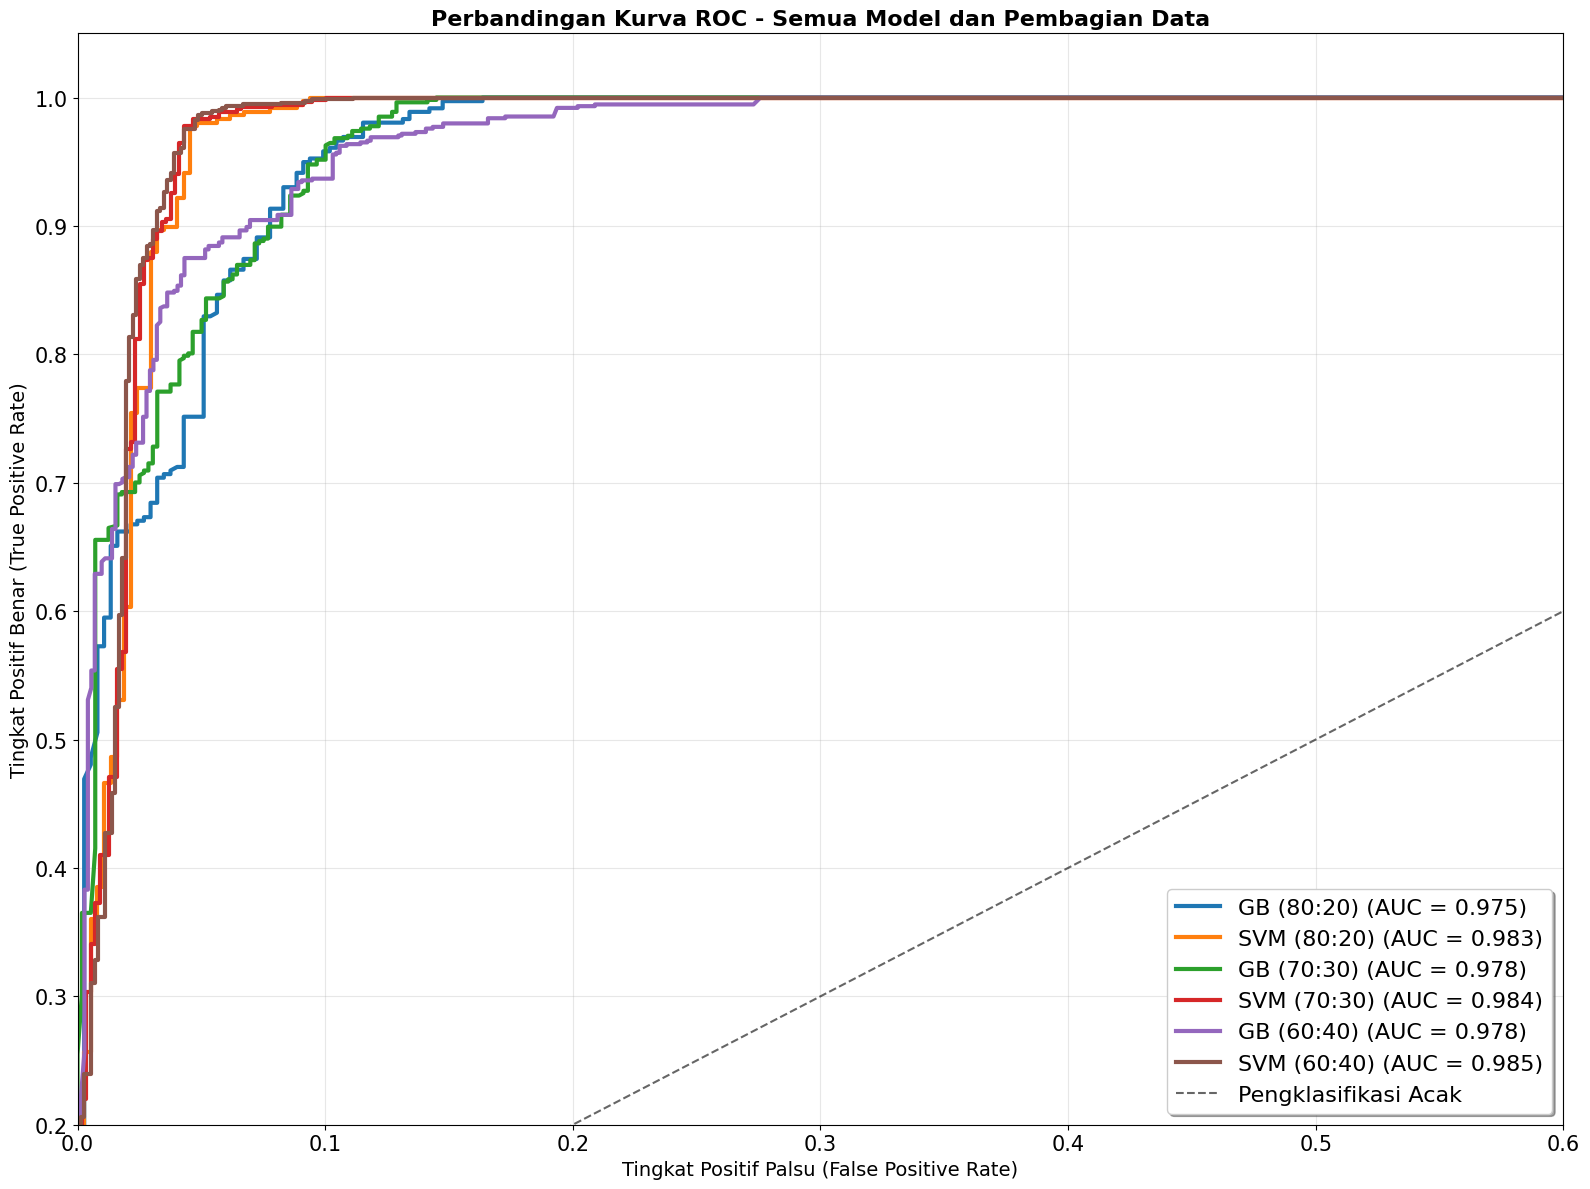

In [45]:
# Combine all models into a single dictionary
all_models = {"GB (80:20)": (gb_80_20, X_val_80, y_val_80), "SVM (80:20)": (svm_80_20, X_val_80, y_val_80), "GB (70:30)": (gb_70_30, X_val_70, y_val_70), "SVM (70:30)": (svm_70_30, X_val_70, y_val_70), "GB (60:40)": (gb_60_40, X_val_60, y_val_60), "SVM (60:40)": (svm_60_40, X_val_60, y_val_60),}

# Plot all ROC curves on a single plot
plt.figure(figsize=(16, 12))

for model_name, (model, X_test, y_test) in all_models.items():
    # Get predictions
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, linewidth=3, label=f'{model_name} (AUC = {auc_score:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Pengklasifikasi Acak')

# Customize plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([0.0, 0.6])  
plt.ylim([0.2, 1.05]) 
plt.xlabel('Tingkat Positif Palsu (False Positive Rate)', fontsize=14)
plt.ylabel('Tingkat Positif Benar (True Positive Rate)', fontsize=14)
plt.title('Perbandingan Kurva ROC - Semua Model dan Pembagian Data', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=16, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- Pelatihan Model SVM dan Gradient Boosting dengan data testing menggunakan rasio terbaik dari tiap algortima (SVM = 60:40, Gradient Boosting = 80:20)


In [46]:
# SVM terbaik (60:40)
svm_best = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, class_weight='balanced', random_state=42)
svm_best.fit(X_train_60, y_train_60)

# Gradient Boosting terbaik (80:20)
gb_best = GradientBoostingClassifier(learning_rate=0.05, max_depth=3, n_estimators=50, random_state=42)
gb_best.fit(X_train_80, y_train_80, sample_weight=weights_80)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=50, random_state=42)

- Evaluasi Model SVM dan Gradient dengan Data testing (akurasi, presisi, recall, F1-Score)

In [47]:
# Pisahkan fitur dan label dari data_testing
X_test_final = data_testing.drop(columns=['TB/U'])
y_test_final = data_testing['TB/U']

# Prediksi dan evaluasi
svm_pred_final = svm_best.predict(X_test_final)
gb_pred_final = gb_best.predict(X_test_final)

# Evaluasi akhir
print("\nEvaluasi Akhir: SVM (Terbaik - 60:40)")
display_evaluation_metrics_without_support("SVM (Final Testing)", y_test_final, svm_pred_final)
print("\nEvaluasi Akhir: Gradient Boosting (Terbaik - 80:20)")
display_evaluation_metrics_without_support("Gradient Boosting (Final Testing)", y_test_final, gb_pred_final)


Evaluasi Akhir: SVM (Terbaik - 60:40)

Model: SVM (Final Testing)
Accuracy	: 84.67%
Precision	: 84.82% (macro average)
Recall		: 84.67% (macro average)
F1-Score	: 84.65% (macro average)

Metrik Per Kelas:
Class 0:
  Akurasi       : 74.16%
  Precision     : 82.50%
  Recall        : 88.00%
  F1-Score      : 85.16%
  Support       : 75
Class 1:
  Akurasi       : 72.62%
  Precision     : 87.14%
  Recall        : 81.33%
  F1-Score      : 84.14%
  Support       : 75

Evaluasi Akhir: Gradient Boosting (Terbaik - 80:20)

Model: Gradient Boosting (Final Testing)
Accuracy	: 78.67%
Precision	: 78.75% (macro average)
Recall		: 78.67% (macro average)
F1-Score	: 78.65% (macro average)

Metrik Per Kelas:
Class 0:
  Akurasi       : 65.59%
  Precision     : 77.22%
  Recall        : 81.33%
  F1-Score      : 79.22%
  Support       : 75
Class 1:
  Akurasi       : 64.04%
  Precision     : 80.28%
  Recall        : 76.00%
  F1-Score      : 78.08%
  Support       : 75


(0.7866666666666666,
 0.7874844000713139,
 0.7866666666666666,
 0.7865148550080057,
 array([[61, 14],
        [18, 57]], dtype=int64))

- Evaluasi Model SVM dan Gradient dengan Data testing (confusion matrix)

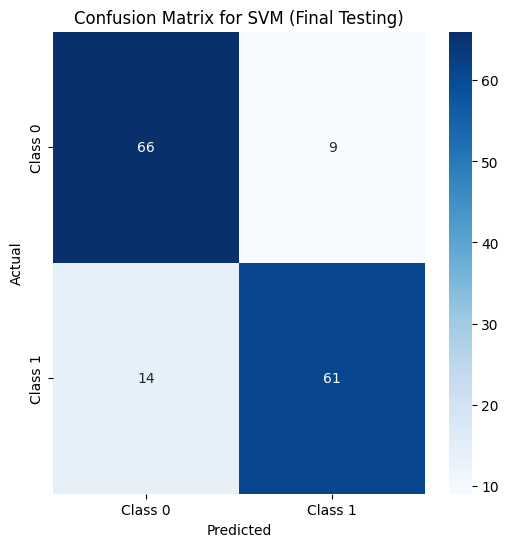

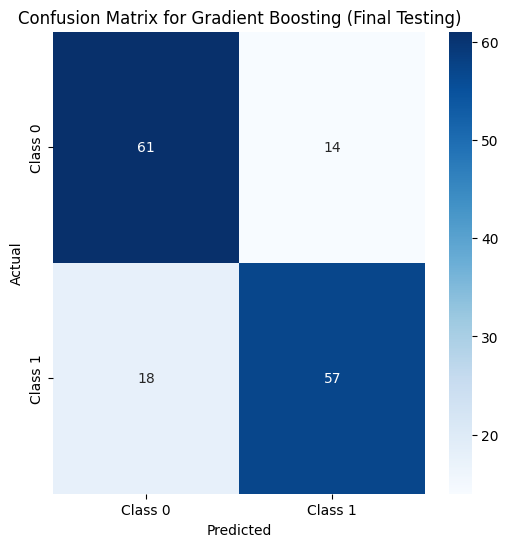

array([[61, 14],
       [18, 57]], dtype=int64)

In [48]:
plot_confusion_matrix(y_test_final, svm_pred_final, "SVM (Final Testing)")
plot_confusion_matrix(y_test_final, gb_pred_final, "Gradient Boosting (Final Testing)") 

- Evaluasi Model SVM dan Gradient dengan Data testing (kurva ROC)

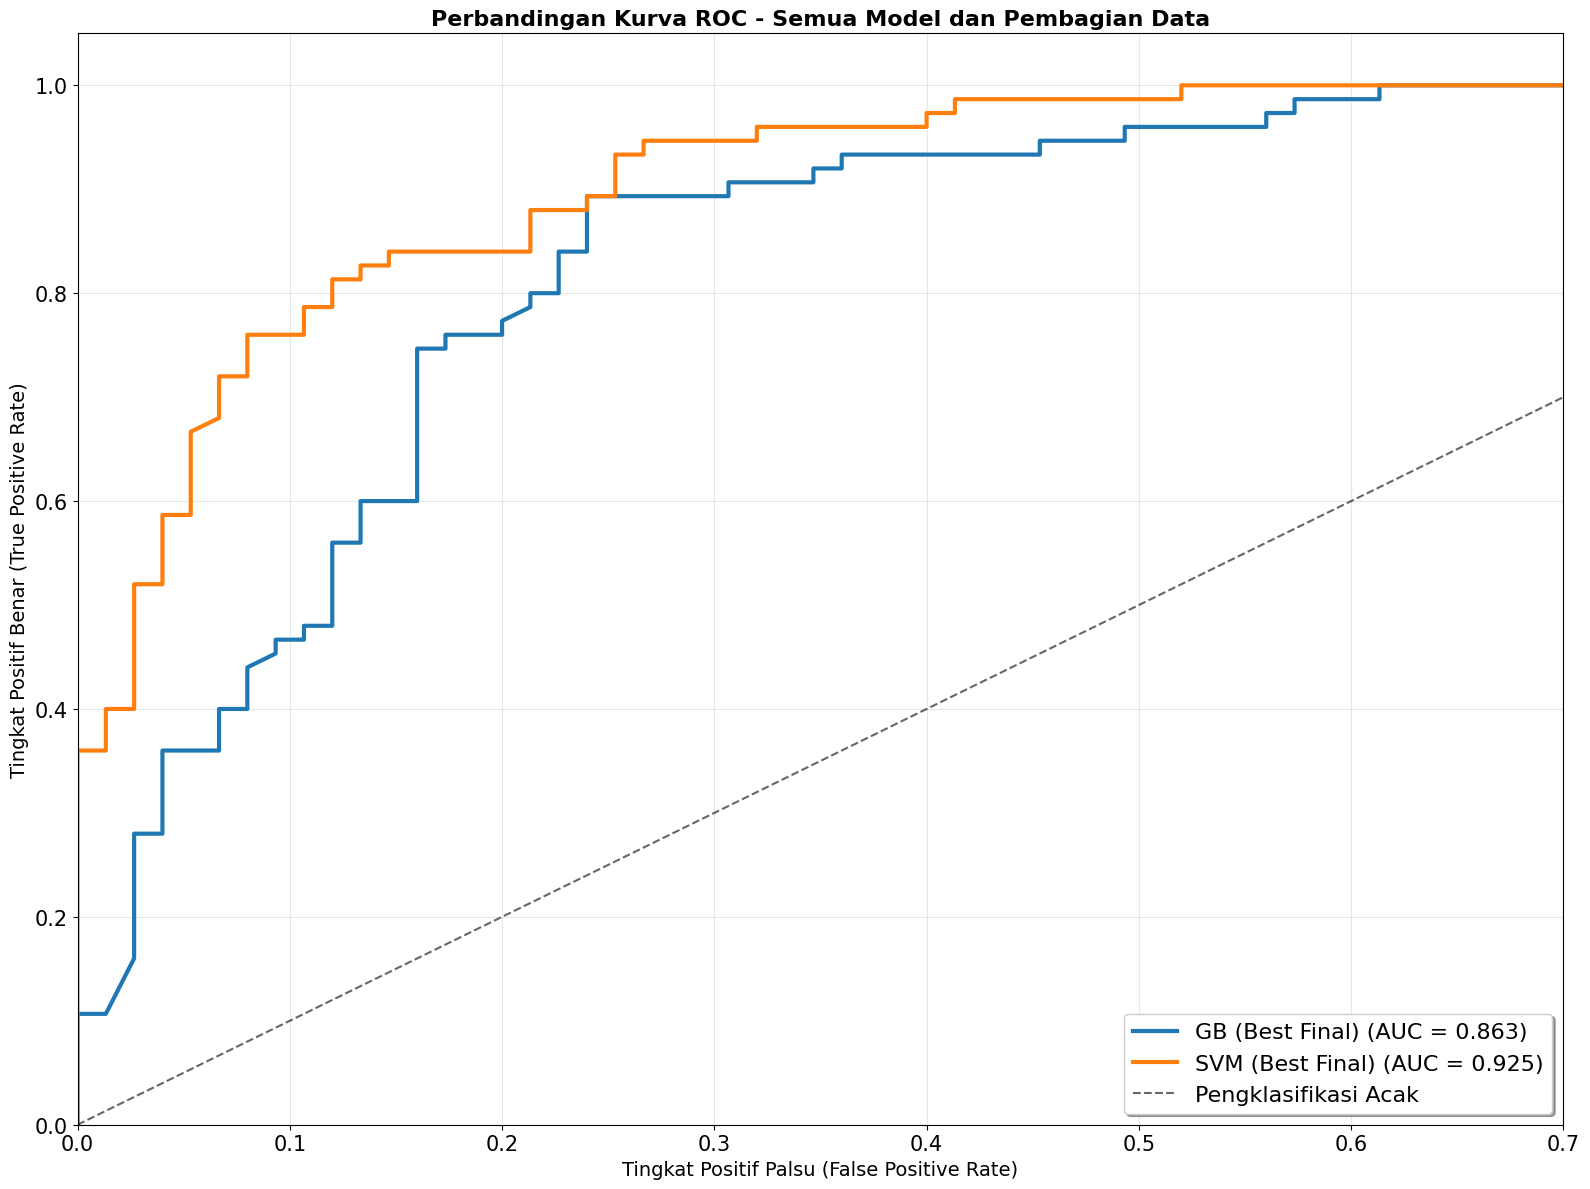

In [49]:
# Combine all models into a single dictionary
all_models = {
    "GB (Best Final)": (gb_best, X_test_final, y_test_final),
    "SVM (Best Final)": (svm_best, X_test_final, y_test_final),}

# Plot all ROC curves on a single plot
plt.figure(figsize=(16, 12))

for model_name, (model, X_test, y_test) in all_models.items():
    # Get predictions
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, linewidth=3, label=f'{model_name} (AUC = {auc_score:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Pengklasifikasi Acak')

# Customize plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([0.0, 0.7])  
plt.ylim([0.0, 1.05]) 
plt.xlabel('Tingkat Positif Palsu (False Positive Rate)', fontsize=14)
plt.ylabel('Tingkat Positif Benar (True Positive Rate)', fontsize=14)
plt.title('Perbandingan Kurva ROC - Semua Model dan Pembagian Data', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=16, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- Perbandingan Evaluasi Model: SVM vs Gradient Boosting dengan data validasi

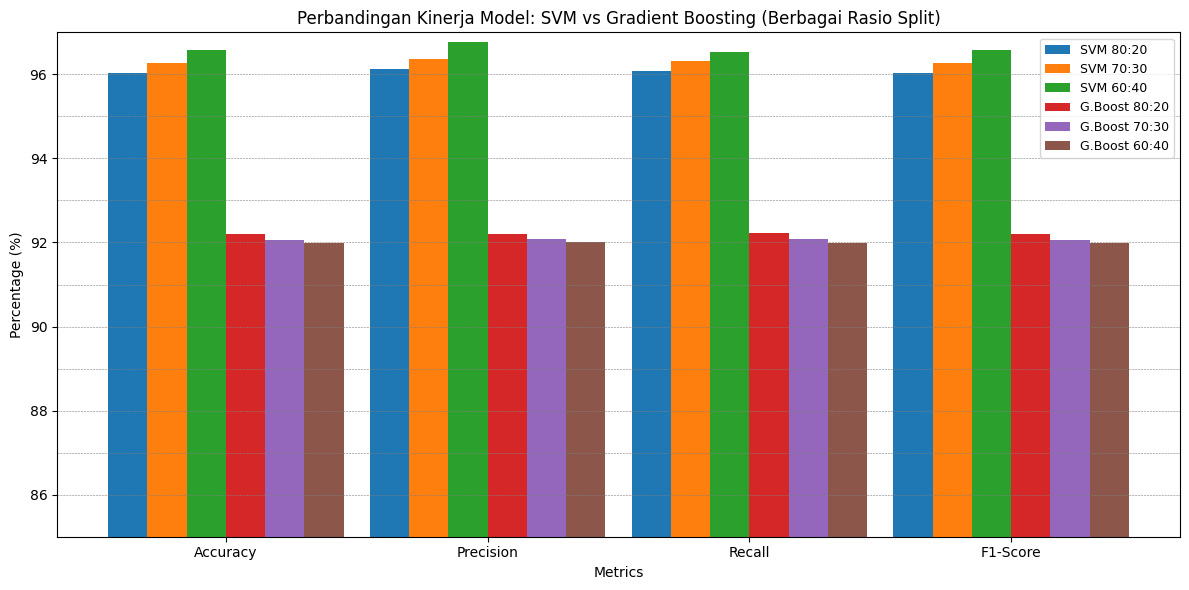

In [50]:
# Dataframe untuk plotting
data_plot = {
    'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1-Score'], 'SVM 80:20': [accuracy_svm_80, precision_svm_80, recall_svm_80, f1_svm_80], 'SVM 70:30': [accuracy_svm_70, precision_svm_70, recall_svm_70, f1_svm_70], 'SVM 60:40': [accuracy_svm_60, precision_svm_60, recall_svm_60, f1_svm_60],'GBoost 80:20': [accuracy_80, precision_80, recall_80, f1_80], 'GBoost 70:30': [accuracy_70, precision_70, recall_70, f1_70],'GBoost 60:40': [accuracy_60, precision_60, recall_60, f1_60]}

df_plot = pd.DataFrame(data_plot)

# Konversi ke persen
for col in df_plot.columns[1:]:
    df_plot[col] = df_plot[col] * 100

# Plotting
x = np.arange(len(df_plot['Metrics']))
width = 0.15  # Lebar bar lebih kecil agar lebih rapat

fig, ax = plt.subplots(figsize=(12, 6))

# Bar chart yang lebih rapat
ax.bar(x - 2.5*width, df_plot['SVM 80:20'], width, label='SVM 80:20')
ax.bar(x - 1.5*width, df_plot['SVM 70:30'], width, label='SVM 70:30')
ax.bar(x - 0.5*width, df_plot['SVM 60:40'], width, label='SVM 60:40')
ax.bar(x + 0.5*width, df_plot['GBoost 80:20'], width, label='G.Boost 80:20')
ax.bar(x + 1.5*width, df_plot['GBoost 70:30'], width, label='G.Boost 70:30')
ax.bar(x + 2.5*width, df_plot['GBoost 60:40'], width, label='G.Boost 60:40')

# Tambahkan garis horizontal putus-putus
for y in range(85, 97):
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.4)

# Format plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Percentage (%)')
ax.set_title('Perbandingan Kinerja Model: SVM vs Gradient Boosting (Berbagai Rasio Split)')
ax.set_xticks(x)
ax.set_xticklabels(df_plot['Metrics'])
ax.set_ylim(85, 97)

# Legend di dalam area plot
ax.legend(loc='upper right', fontsize=9, frameon=True)

plt.tight_layout()
plt.show()

- Perbandingan Evaluasi Model: SVM vs Gradient Boosting dengan data testing

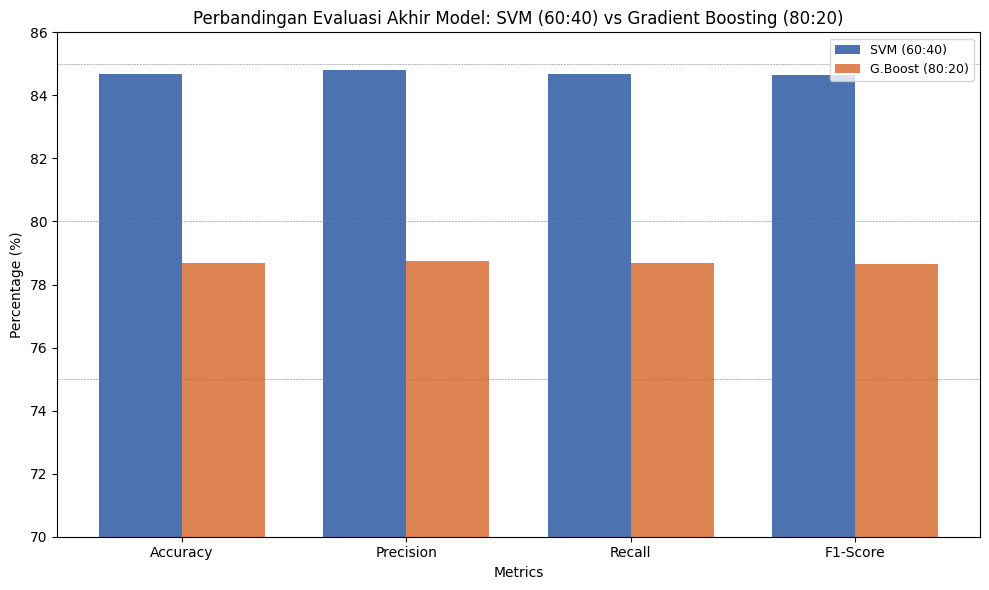

In [51]:
# Data evaluasi akhir (dari data testing)
data_final_plot = {
    'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'SVM (60:40)': [84.67, 84.82, 84.67, 84.65],
    'G.Boost (80:20)': [78.67, 78.75, 78.67, 78.65]
}

df_final_plot = pd.DataFrame(data_final_plot)

# Plotting
x = np.arange(len(df_final_plot['Metrics']))
width = 0.37

fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart dua model
ax.bar(x - width/2, df_final_plot['SVM (60:40)'], width, label='SVM (60:40)', color='#4c72b0')
ax.bar(x + width/2, df_final_plot['G.Boost (80:20)'], width, label='G.Boost (80:20)', color='#dd8452')

# Tambahkan garis horizontal putus-putus
for y in range(70, 91, 5):
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.4)

# Format plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Percentage (%)')
ax.set_title('Perbandingan Evaluasi Akhir Model: SVM (60:40) vs Gradient Boosting (80:20)')
ax.set_xticks(x)
ax.set_xticklabels(df_final_plot['Metrics'])
ax.set_ylim(70, 86)

# Legend
ax.legend(loc='upper right', fontsize=9, frameon=True)

plt.tight_layout()
plt.show()
